# *Necessary Imports*

In [20]:
import numpy as np
import pandas as pd
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense,Dropout,Flatten
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
from sklearn import preprocessing
#from sklearn_model_selection import train_test_split
import cv2


# **Loading the .npy files**
*The csv were converted to npy in the CNN task and thus not repeated here*

In [2]:
%cd /content/drive/MyDrive/URC/Fashion_MNIST/Test
testX = np.load('fashion-mnist_test_X.npy') 
testY = np.load('fashion-mnist_test_Y.npy')

%cd /content/drive/MyDrive/URC/Fashion_MNIST/Validation
validationX = np.load('validation20k_X.npy')
validationY = np.load('validation20k_Y.npy')

%cd /content/drive/MyDrive/URC/Fashion_MNIST/Train
trainX = np.load('fashion-mnist_train40k_X.npy')
trainY = np.load('fashion-mnist_train40k_Y.npy')

/content/drive/MyDrive/URC/Fashion_MNIST/Test
/content/drive/MyDrive/URC/Fashion_MNIST/Validation
/content/drive/MyDrive/URC/Fashion_MNIST/Train


## Preprocessing Functions


*   ***reshape_image()*** :

  ~*VGG19 is only applicable to RGB images thus we concatenate the grayscale  image 3 times along the 4th dimension.*

  ~*VGG19 needs a minimum dimension of 32x32 thus we pad the input by 2 units each*
*   ***preprocessY()***:

 ~*converting the labels and Ydata in a form comprehendible by the network*



In [3]:
def reshape_image (data, size):
  data = np.array(data)
  print(data.shape)
  data = data.reshape(size, 28, 28)
  data = np.repeat(data[..., np.newaxis], 3, -1) # concatenating 3 times in 4th dimension
  data = np.pad(data,((0,0),(2,2),(2,2),(0,0)),mode = 'edge') 
  return data

In [4]:
#trainX = reshape_image(trainX, trainX.shape[0])
trainX = reshape_image(trainX, trainX.shape[0])
testX = reshape_image(testX, testX.shape[0])
validationX = reshape_image(validationX, validationX.shape[0])

(40000, 784)
(10000, 784)
(20000, 784)


In [5]:
validationX.shape

(20000, 32, 32, 3)

In [6]:
def preprocessY (lst):
  integer_encoded = label_encoder.fit_transform(np.array(lst))
  trainY = to_categorical(integer_encoded)
  #trainY = to_categorical(lst)
  return trainY

In [7]:
trainY = preprocessY(trainY)
testY = preprocessY(testY)
validationY = preprocessY(validationY)

In [8]:
trainX.shape

(40000, 32, 32, 3)

# ***Importing the Pretrained Model***



In [9]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

base_model = VGG19(weights = 'imagenet' ,include_top = False, input_shape =(32,32,3), classes = 10)

#reason for include_top - False as to train a new output layer according to our needs
#pretrained weights are being used of 'imagenet' 
x = base_model.output

#adding the output layer according to our classes required - 10
x  = Flatten()(x)
predictions = Dense(10,activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

#onl training the Dense Layer
for layer in base_model.layers:
  layer.trainable = False

#Compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [10]:
#Augmenting the dataset so as to diversify it
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

**Checkpoint Basics**

In [11]:
checkpoint_path = "/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Tweaking the batch_size parameters

In [61]:
input_shape=(32, 32, 3)
#batch_size =128
#after 21 epochs
#batch_size = 64
batch_size = 1024
#batch_size = 4096

Loading weights in case of a crash

In [62]:
model.load_weights('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-0056.ckpt')#.ckpt file of weights you want to load

The training cell

In [63]:
#training cell
history=model.fit_generator(gen.flow(trainX, trainY, batch_size), 
                    steps_per_epoch=trainY.shape[0]//batch_size, 
                    epochs=70, initial_epoch = 56, 
                    validation_data=gen.flow(validationX, validationY, batch_size),
                    validation_steps=validationY.shape[0]//batch_size,
                    callbacks=[cp_callback]
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 57/70
9/9 [==============================] - 50s 4s/step - loss: 0.4557 - accuracy: 0.8316 - val_loss: 0.5353 - val_accuracy: 0.8154

Epoch 00057: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-0057.ckpt
Epoch 58/70
9/9 [==============================] - 25s 3s/step - loss: 0.4537 - accuracy: 0.8343 - val_loss: 0.5359 - val_accuracy: 0.8129

Epoch 00058: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-0058.ckpt
Epoch 59/70
9/9 [==============================] - 26s 3s/step - loss: 0.4563 - accuracy: 0.8327 - val_loss: 0.5257 - val_accuracy: 0.8188

Epoch 00059: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-0059.ckpt
Epoch 60/70
9/9 [==============================] - 25s 3s/step - loss: 0.4485 - accuracy: 0.8332 - val_loss: 0.5234 - val_accuracy: 0.8192

Epoch 00060: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/cp-0060.ckpt
Epoch 61/70
9/9 [===================

Saving the model for further evaluation

In [64]:
model.save('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/65iterationstrial5.h5')

Further Evaluation

In [65]:
from tensorflow.keras.models import load_model

In [66]:
 # loading the model

#model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/model_bs_64_f_128each25epoch.h5')#88
#model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/rough2.h5')#90
model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/VGG19/65iterationstrial5.h5')

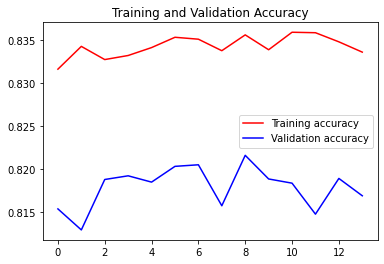

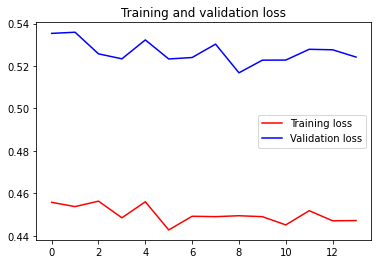

In [67]:
#plotting the graphs

#getting all the keys
history.history.keys()
his = history
accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']
epochs = range(len(accuracy))

#Training and Validation Accuracy vs Epoch
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()


#Training Loss and Validation Loss vs Epoch
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [68]:
#Testing Loss and Accuracy  
score = model.evaluate(testX, testY, verbose = 0)
print('Test Loss:' , score[0])
print('Test accuracy', score[1])

Test Loss: 0.519935131072998
Test accuracy 0.8185999989509583
